# Inteligentni sistemi genetsko programiranje za simbolično regresijo
**Genetski algoritm napisan v Pythonu**

Avtorja:

Luka Premuš, Domen Beden


### Knjižnice:

In [8]:
import pandas as pd
from r import *
from r2 import *
import json
import math
from sympy import simplify
import matplotlib.pyplot as plt


data = pd.read_csv("./dataset.csv")
formule = data['Equation']


## Generiranje populacije

Za začetek delovanja genetskega algoritma je potrebna začetna populacija. V našem primeru je primerek iz populacije aritmetični izraz. 

Pri generiranju aritmetičnih izrazov naključno izberamo operacije in vrednosti v izrazih. 

**Možne operacije**: seštevanje (+), odštevanje (-), množenje (*), deljenje (/) in potenciranje (**)

**Možne vrednosti**: števila od 1 do 9, neodvisna spremenljivka $x$, naravni logaritem od števil 1 do 9, naravni logaritem od spremenljivke $x$ sinus od spremenljivke $x$, kosinus od spremenljivke $x$, od števil 1 do 9 in kosinus od števil 1 do 9. V naboru vrednosti, ki jih izbira algoritem pri izdelavi artimetične enačbe, se izbor "števila od 1 do 9" ponovi večkrat, saj s tem imajo večjo verjetnost, da so izbrane številke pri generaciji. S tem se izogneva izdelavi pretirane kompleksnosti enačb. 

Nato naključno generiramo število vrednosti, ki se nahaja med naravnim številom podanim z argumentom *numTerms* in *numTerms + 2*.

Funkcija *generate_expression* poleg tega da naključno izbira operacije in vrednosti, poskrbi tudi, da se v izrazu nahaja vsaj ena neodivsna spremenljivka $x$.

Funkcija se strogo izogiba enačbam, ki vsebujejo $x^{x}$. Te enčbe se izkažejo za težko obvladljive in hitro pride do **preliva** (ang. *Overflow*). 

In [9]:
def generate_expression(numTerms, x_index):
    operators = ["+", "-", "*","/", "**"]
    vals = [str(random.randint(1, 9)),str(random.randint(1, 9)),
            str(random.randint(1, 9)),str(random.randint(1, 9)),
            str(random.randint(1, 9)),
              "x", f"log{str(random.randint(1,9))}",
              "logx","sinx","cosx",
              f"sin{str(random.randint(1,9))}",
              f"cos{str(random.randint(1,9))}"]
    vals2 = str(random.randint(1, 9))
    
    num_terms = random.randint(numTerms, 2+numTerms)
    
    x_index %= numTerms
    correct = False
    while not correct:
        correct = True
        terms = []
        del terms[:]
        x = 0
        for i in range(num_terms):
            
            op = random.choice(operators)
            num = random.choice(vals)

            if x_index == i:
                if i > 0 and terms[i-1] == "**":
                    correct = False
                    break     #da ne dobimo neki**x
                else:
                    num = "x"
                    x += 1
            else:
                if i > 0 and terms[i-1] == "**":
                    
                    if num == "x":
                        correct = False
                        break
            terms.append(num)
            terms.append(op)

        terms.append(vals2)
        expression = "".join(terms)

    return expression

Primeri 15 generiranih enačb z minimalno petimi vrednostmi:

In [10]:
for i in range(15):
    equation = generate_expression(5, i)
    print(f"{i}: {equation}")


0: x**cosx**sinx**9+1-9/7
1: logx/x**x+logx-cos3-8
2: 1*1*x**x+cosx*1
3: logx/cosx/4-x/sin6/2-4
4: x+6*sinx-3+x**log2-3+3
5: x+sin3*cos6/sin3+sinx*x**4
6: sin3-x/sin3/logx-1*8
7: log6*3**x-sinx**cosx+8
8: 8**cosx/log2+x**4**x+4
9: 3**logx/6/3-x*3
10: x*logx/4+log1+3+3-6
11: log7+x**sinx**6+logx*sin4+6*2
12: cosx-logx**x-2/2/x*3
13: cosx-3/logx*x**cos5+5
14: cosx+6-x+6*x-cosx/x*2


In [13]:
equationIndex = 10

def ga(N, gen, equationIndex):
    
    prevN = N
    best_of_gens = {}
    for i in range(gen):
        # print(i+1)
        results = {}
        N = prevN

        for i in range(N):
            expression = generate_expression(5, i)
            fitness = fitness_MSE(expression, data, equationIndex)
            results[fitness] = expression
    
        N = N // 2
        
        result = sort_dict(results)
        new_dict = dict(list(result.items())[:N])

        # [1,1,3,3,3,3,3,3,3,3,3,3,3,3,3]
        # [0,0,0,0,0,0,1, 1,1, 2,3,3,3,3, 3]
        while N > 1:
            for ele in new_dict:
                mutation_choice = random.choice([1,1,1,2,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3])

                if mutation_choice == 1:
                    expression = arr_to_string(mutate_value(result[ele]))   
                    fitness = fitness_MSE(expression, data, equationIndex)
                    
                    result[fitness] = expression
                if mutation_choice == 2:
                    expression = arr_to_string(mutate_operation(result[ele]))

                    fitness = (fitness_MSE(expression, data, equationIndex))
                    result[fitness] = expression

                if mutation_choice == 3:
                    tree1, tree2 = pick2trees(new_dict)
                    tree1, tree2 = crossover(tree1, tree2)

                    #ce ni x v enacbi ponavlja 
                    while(check_if_x(tree1) == False) or (check_if_x(tree2) == False):
                        tree1_str = print_infix_parenthesis(tree1)

                        tree2_str = print_infix_parenthesis(tree2)
                        # print(f"tree1: {tree1_str}, tree2: {tree2_str}")
                        tree1,tree2 = crossover(tree1,tree2)
                        

                    tree1_str = infixString(tree1)
                    tree2_str = infixString(tree2)
                    
                    fitness1 = fitness_MSE(tree1_str, data, equationIndex)
                    fitness2 = fitness_MSE(tree2_str, data, equationIndex)


                    result[fitness1] = tree1_str
                    result[fitness2] = tree2_str

                    

            N = N // 2
            result = sort_dict(results)
            new_dict = dict(list(result.items())[:N]) 
        
        #vrne najboljsega iz generacije
        val = list(sort_dict(results))[0]
        # val = [simplify(results[]) : e in ]
        best_of_gens[val] = (results[val])
        # best_of_gens[val] = simplify(results[val])

        # print("best of gen: " + results[val] + " " + str(val))

    return best_of_gens

k = ga(100, 100, equationIndex)
k = sort_dict(k)


val = list(k)[0]

row = data.iloc[equationIndex]
Xs = json.loads(row['Xs'])

Ys = json.loads(row['Ys'])
real_eq = row['Equation']
print("---------------------")

print(real_eq)
print("---------------------")

print(k[val], val)




---------------------
(((x - 2) + 4) * 5)
---------------------
x*2+x-x+x*5 1.18374


In [14]:
function_accuracy = []

for eqIndex in range(0, len(data)):
    
    k = ga(1000, 20, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    row = data.iloc[eqIndex]
    Xs = json.loads(row['Xs'])

    Ys = json.loads(row['Ys'])
    real_eq = row['Equation']
    print("---------------------")
    print(f"{eqIndex} - real eq: " + real_eq)
    print("=====================")
    print(k[val], val)
    print("---------------------")
    function_accuracy.append(val)



---------------------
0 - real eq: ((x ** 4) - 6)
x*logx*x**3/4+6 2.03635
---------------------
---------------------
1 - real eq: (((x / 8) * 2) + 1)
x/4+3/4**3/1 1.2375
---------------------
---------------------
2 - real eq: (((x - 1) - 3) / 5)
x/3/2-3/x/5 1.12331
---------------------
---------------------
3 - real eq: (x * 5)
1*x/6+x/1*5 1.10089
---------------------
---------------------
4 - real eq: (x + 2)
x+2-2-2+2+4 1.11117
---------------------
---------------------
5 - real eq: ((x + 1) * 7)
1/1/1*7*x+7 1.1
---------------------
---------------------
6 - real eq: ((x + 2) ** 9)
2**x*4**x/cos6**2*7 20.16012
---------------------
---------------------
7 - real eq: (x * 2)
1+1*x*2-1/4 1.10302
---------------------
---------------------
8 - real eq: (((x ** 8) * 5) / 3)
3+x**6*x**logx*3-3+6 5.28713
---------------------
---------------------
9 - real eq: (x / 7)
2-x-2+x+x/8 1.13363
---------------------
---------------------
10 - real eq: (((x - 2) + 4) * 5)
x+x*4/1+1*7 1.10158

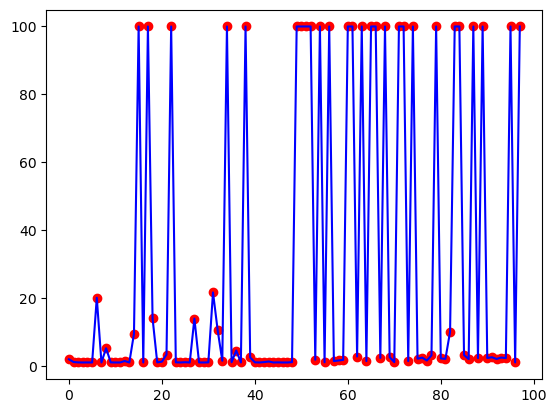

In [28]:
values = function_accuracy.copy()

values = [100 if v > 100 else v for v in values]

xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')


In [16]:
function_accuracy1 = []
for eqIndex in range(0, len(data)):
    
    k = ga(200, 40, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy1.append(val)

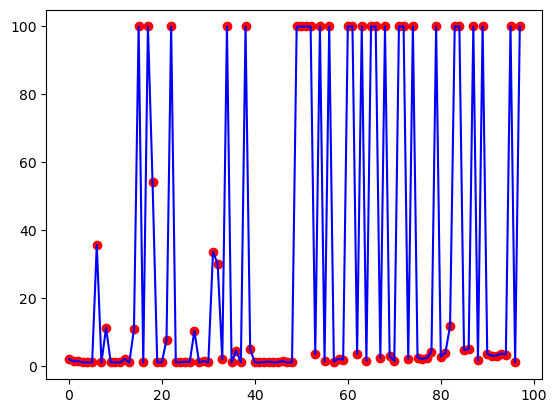

In [17]:
values = function_accuracy1.copy()

values = [100 if v > 100 else v for v in values]

xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [18]:
function_accuracy2 = []
for eqIndex in range(0, len(data)):
    
    k = ga(500, 500, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy2.append(val)

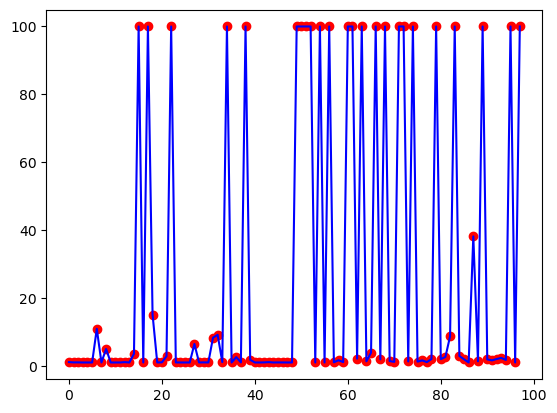

In [19]:
values = function_accuracy2.copy()

values = [100 if v > 100 else v for v in values]

xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [20]:
function_accuracy3 = []
for eqIndex in range(0, len(data)):
    
    k = ga(100, 100, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy3.append(val)

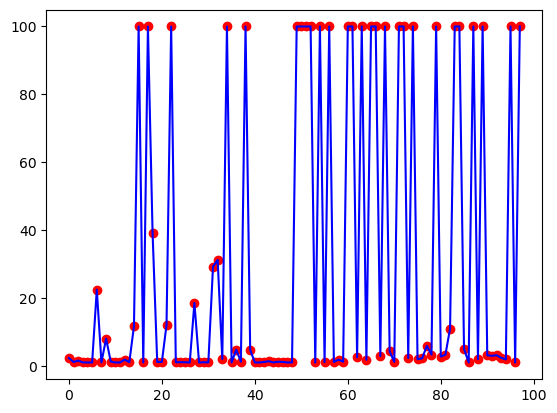

In [21]:
values = function_accuracy3.copy()

values = [100 if v > 100 else v for v in values]

xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [22]:
function_accuracy4 = []
for eqIndex in range(0, len(data)):
    
    k = ga(800, 50, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy4.append(val)

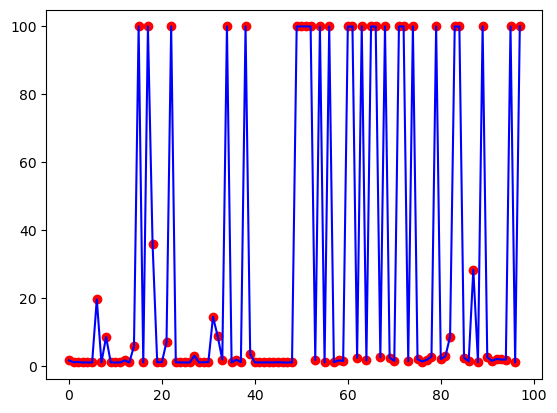

In [23]:
values = function_accuracy4.copy()

values = [100 if v > 100 else v for v in values]

xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')

In [24]:
function_accuracy5 = []
for eqIndex in range(0, len(data)):
    
    k = ga(200, 300, eqIndex)
    k = sort_dict(k)

    val = list(k)[0]

    function_accuracy5.append(val)

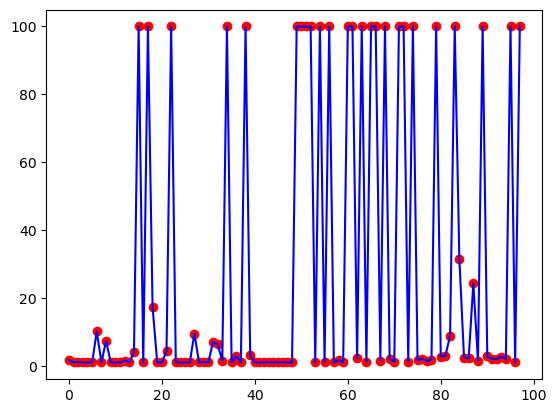

In [25]:
values = function_accuracy5.copy()

values = [100 if v > 100 else v for v in values]

xs = np.arange(98)
plt.scatter(xs,values,color='red',marker='o')
plt.plot(xs,values,color='blue')